# CNN built from scratch to solve SETI Breakthrough Listen Kaggle challenge

This notebook aims to use a handcrafted CNN deep learning model to solve the SETI Breakthrough Listen Kaggle challenge:
-  https://www.kaggle.com/competitions/seti-breakthrough-listen

## Install Python Packages

In [7]:
# Used for transforming images
!pip install albumentations

# Installs CUDA version of PyTorch, allowing to run on a GPU
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

# Used for displaying model summaries
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Python Packages

In [8]:
# Utility packages
import os
import random
from datetime import datetime
import time
import zipfile
from io import BytesIO

# PyTorch packages for training a model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

# Utility package used to visualise CNN filters
from torchvision import utils

# Scikit learn packages
from sklearn.decomposition import NMF # Used to factorise an image into two matrices
from sklearn.metrics import roc_auc_score, classification_report # metric reporting

# OpenCV package used to transform images
import cv2

# Packages to help with data wrangling
import numpy as np
import pandas as pd

# Used to plot graphs
from matplotlib import pyplot as plt

# Used to transform images
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

## Global Configuration

A global configuration object, allowing important variables to be easily changed and referenced.

In [9]:
config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-6,
    'weight_decay': 1e-4,
    'batch_size': 50,
    'epochs': 50,
    'num_folds': 1
}

## Random Seed Initalisation

Sets the seeds for random functions to fixed values.

This allows the results in this notebook to be reproducible.

In [10]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



set_seeds(seed=config['seed'])

## Data Loading

The dataset labels are loaded from file.

These are then stored in a Pandas DataFrame for convenience.

In [11]:
# # build the path to the labels file
# data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
# labels_filepath = os.path.join(data_dir, '500_balanced_labels.npy')

# # open as a Numpy pickle file
# with open(labels_filepath, 'rb') as f:
#     initial_data = np.load(f, allow_pickle=True)

# # load into a Pandas dataframe
# initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
# initial_data_df['target'] = initial_data_df['target'].astype('int')

'''
Extract the data samples from a zip file and return in a dictionary object.
'''
def extract_zip(input_zip):
    zip_file = zipfile.ZipFile(input_zip)

    return {name: zip_file.read(name) for name in zip_file.namelist()}



# Extract the data samples from a zip file.
dataset = extract_zip('/content/drive/MyDrive/Final Project/2000 dataset/2000.zip')

# Load the data samples labels.
data_samples = np.load(BytesIO(dataset['2000/' + '2000_balanced_labels.npy']), allow_pickle=True)

# Load the data samples labels in a dataframe for convenience.
initial_data_df = pd.DataFrame(data_samples, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

In [12]:
initial_data_df = initial_data_df.sample(frac=1).reset_index(drop=True)

We can see that the training dataset consists of the following fields:

- `id`: The ID of the data sample.
- `target`: The ground truth label sample.
- `image_filepath`: The location of the image file on disk.

In [13]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2000 non-null   string
 1   target          2000 non-null   int64 
 2   image_filepath  2000 non-null   string
dtypes: int64(1), string(2)
memory usage: 47.0 KB


Split the data into 70% train and 30% test:

In [14]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

## Image Utility Functions

Define a set of utility functions for manipulating images.

In [15]:
'''
Resizes an image to the specified size.
'''
def resize_image(image):
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)



'''
Plots an image.
'''
def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()




'''
Min-max normalises the image pixel values (between 0 and 1).
'''
def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)



'''
Factorises an image into two matrices, and returns them.
Used to help remove image background noise.
'''
def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)



'''
Removes the background noise from a set of sample images.

Based on: https://www.kaggle.com/competitions/seti-breakthrough-listen/discussion/245950
'''
def get_denoised_image(sample_images):
    combined_on_images = None
    combined_off_images = None
    combined_denoised_image = None

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i] # Get on target image
        off_target_image = sample_images[i+1] # Get off target image

        on_W, on_H = get_decomposition_matrices(on_target_image) # Decompose on target images into factor matrices
        off_W, off_H = get_decomposition_matrices(off_target_image) # Decomponse off target images into factor matrices

        # Get noise approximation by multiplying a factor matrix from each of the on target, and off target images.
        # Then subtract the approximated noise from the on target images
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))

        # Consolidate the on target, off target and denoised images.
        combined_on_images = on_target_image if combined_on_images is None else combined_on_images + on_target_image
        combined_off_images = off_target_image if combined_off_images is None else combined_off_images + off_target_image
        combined_denoised_image = denoised_image if combined_denoised_image is None else combined_denoised_image + denoised_image

    # Return the denoised image
    return combined_denoised_image



'''
Combines normalised on target images into a single one and returns it.
'''
def get_combined_image(sample_images):
  combined_image = None

  for i in range(0, len(sample_images), 2):
    on_target_image = normalise_image(sample_images[i])

    combined_image = on_target_image if combined_image is None else combined_image + on_target_image

  return combined_image

## Custom Dataset

An implementation of the PyTorch `Dataset` class.

Used by the model to access a data sample.

In [16]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        # the sample image is loaded from a Numpy pickle file on disk
        # images_filepath = self.images_filepaths[idx]
        # images = np.load(images_filepath).astype(np.float32)
        
        images_filepath = self.images_filepaths[idx]
        images_filepath = images_filepath.replace('\\', '/')
        file_name = os.path.basename(images_filepath)
        images_filepath = '2000/' +  file_name

        images = np.load(BytesIO(dataset[images_filepath]), allow_pickle=True).astype(np.float32)

        # get on target images as a single normalised image
        image = get_combined_image(images)

        # apply image transformations if requested
        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()

        label = torch.tensor(self.targets[idx]).float()

        return image, label

## Image Augmentation

Helper functions for transforming images.

These can be used to help prevent overfitting on the available data samples.

In [17]:
'''
Returns a set of image transformations using the albumentations library.
'''
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )



'''
Applies transformations for validation image data.

This currently resizes the images.
'''
def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )



'''
Applies transformations for training image data.

This currently resizes the images.
'''
def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Train and Validation Dataloaders

Data loaders for the training and validation data.

These are used during the model training and validation loop.

In [18]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        # transform=get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        # transform=get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size=config['batch_size'],
        # shuffle=True,
        # num_workers=config['num_workers'],
        sampler = sampler,
        pin_memory=True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return train_loader, valid_loader

## Model

The deep learning model that will be trained.

Based on the example from:
- https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/#Example_of_PyTorch_Conv2D_in_CNN

The layers consist of the following:
- Layers 1 - 8:
-- 2D convolutional layer
-- Batch normalisation layer
-- ReLU activation layer
-- 2D max pooling layer

The final layer is a fully connected layer that connects all of the neurons in the previous layer and outputs a binary classification using a confidence score.

The weights for the final layer are randomly initialised.

In [19]:
'''
Create a deep convolutional neural network with a binary classification output.
'''
class CustomModel(nn.Module):
    '''
    This function is called when setting up the model.
    '''
    def __init__(self):
        super().__init__()

        # convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(1204),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer7 = nn.Sequential(
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional layer
        self.layer8 = nn.Sequential(
            nn.Conv2d(2048, 4096, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(4098),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # classification layer
        self.fc1 = nn.Linear(256, 1, bias=True)

        nn.init.xavier_uniform_(self.fc1.weight)

    '''
    This method is called when making a prediction
    '''
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # flatten for FC
        x = self.fc1(x)

        return x

## Model Initialisation

Initialise model, loss criterion, optimiser and learning rate scheduler.

In [20]:
# the model to train
model = CustomModel()
model = model.to(config['device'])

# the loss function used to track loss
# this allows loss to be tracked with an aim of reducing it during training
criterion = nn.BCEWithLogitsLoss().to(config['device'])

# Optimizer used for minimising loss during model training
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

# learning rate scheduler
# starts the learning rate at a high value and reduces by steps over time
scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

## Classification Utility Functions

A set of functions that help get a binary predictions and to measure their accuracy and ROC AUC score.

In [21]:
'''
Min max normalises prediction values.
This places them in the range 0 - 1.
'''
def get_normalised_predictions(predictions):
    predictions_min = min(predictions)
    predictions_max = max(predictions)

    if predictions_min == predictions_max: # all predictions are the same
        return [0] * len(predictions)

    return [(x - predictions_min) / (predictions_max - predictions_min) for x in predictions]



'''
Classifies as false for values below 0.5 and true otherwise.
'''
def get_binary_classification(value):
    return 0 if value < 0.5 else 1



'''
Returns the binary classifications for a set of raw model predictions.
'''
def get_binary_classifications(predictions):
    norm_predictions = np.array(get_normalised_predictions(predictions))
    binary_classification_func = np.vectorize(get_binary_classification)

    return binary_classification_func(norm_predictions)



'''
Returns the accuracy score for a set of predictions.
'''
def get_accuracy(predictions, labels):
    binary_classifications = get_binary_classifications(predictions)
    labels_array = labels.cpu().detach().numpy()
    correct_predictions = (binary_classifications == labels_array)
    correct_predictions_count = np.count_nonzero(correct_predictions)

    return np.mean(correct_predictions_count / len(predictions))



'''
Returns the ROC AUC score for a prediction.
'''
def get_roc_auc_score(output, target):
    try:
        return round(roc_auc_score(target, output), 10)
    except:
        return 0.5 # return 0.5 score if an exception occours, e.g. divide by 0



'''
Evaluates a model by predicting values for a supplied dataset.

Returns loss, accuracy and ROC AUC metrics for the predictions.
'''
def get_validation_loss_accuracy_rocauc(model, data_loader):
    loss = 0
    accuracy = 0
    roc_auc = 0

    # place model in evaluation mode so weights are not updated
    model.eval()

    for x, y in data_loader:
        x, y = x.to(config['device']), y.to(config['device'])

        predictions = model(x)

        loss += criterion(predictions, y.unsqueeze(1)).item()
        accuracy += get_accuracy(predictions.cpu().detach().numpy(), y.unsqueeze(1))
        roc_auc += get_roc_auc_score(predictions, y.unsqueeze(1))


    num_samples = len(data_loader)

    return loss/num_samples, accuracy/num_samples, roc_auc/num_samples

## Training and Validation Loop

The main loop for training and validating the model.

In [22]:
# split data into training and validation set with an 80:20 ratio
data_split_mask = np.random.rand(len(train_df)) < 0.8

train_data = train_df[data_split_mask]
valid_data = train_df[~data_split_mask]

# data sample loaders
train_loader, valid_loader = get_loaders(train_data, valid_data, None)

# global variables used to keep track of metrics
train_losses = []
train_accuracies = []
train_roc_auc_scores = []

valid_losses = []
valid_accuracies = []
valid_roc_auc_scores = []



# the training & validation loop, that runs for the number of epochs specified
for e in range(1, config['epochs']+1):
    # variables to track metrics for the epoch
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_train_roc_auc = 0

    epoch_valid_loss = 0
    epoch_valid_acc = 0
    epoch_valid_roc_auc = 0

    start_time = time.time() # use a timer to track of how long an epoch takes

    # train the model using the training data set
    for train_x, train_y in train_loader:
        # train_x is the batched image samples
        # train_y is the batched labels
        train_x, train_y = train_x.to(config['device']), train_y.to(config['device'])

        # reset the optimizer by zeroing out its gradients
        optimizer.zero_grad()


        # --------
        # Training
        # --------
        model.train() # put model into training mode so weights can be updated

        train_predictions = model(train_x) # get predictions from training set

        # calculate training loss
        train_loss = criterion(train_predictions, train_y.unsqueeze(1))
        epoch_train_loss += train_loss.item()

        # calculate training accuracy
        train_acc = get_accuracy(train_predictions.cpu().detach().numpy(), train_y.unsqueeze(1))
        epoch_train_acc += train_acc.item()

        # calculate training ROC AUC score
        epoch_train_roc_auc += get_roc_auc_score(train_predictions, train_y)


        # ----------
        # Validation
        # ----------
        # run model against validation data and get metrics
        valid_loss, valid_acc, valid_roc_auc = get_validation_loss_accuracy_rocauc(model, valid_loader)

        epoch_valid_loss += valid_loss
        epoch_valid_acc += valid_acc
        epoch_valid_roc_auc += valid_roc_auc


        # -------------------
        # Back propagation
        # -------------------
        train_loss.backward() # update the model weights using back propagation
        optimizer.step() # update the optimizer for reducing loss


    end_time = time.time()

    num_samples = len(train_loader)

    # store the training and validation metrics for the epoch
    train_losses.append(epoch_train_loss / num_samples)
    train_accuracies.append(epoch_train_acc / num_samples)
    train_roc_auc_scores.append(epoch_train_roc_auc / num_samples)

    valid_losses.append(epoch_valid_loss / num_samples)
    valid_accuracies.append(epoch_valid_acc / num_samples)
    valid_roc_auc_scores.append(epoch_valid_roc_auc / num_samples)

    # print the metrics for tracking purposes
    print(f'Epoch {e+0:03}'
          f' | Duration (s): {end_time - start_time}'
    )

    print(f'Train - Loss: {epoch_train_loss / num_samples:.5f}'
          f' | Acc: {epoch_train_acc / num_samples:.3f}'
          f' | ROC AUC: {epoch_train_roc_auc / num_samples:.3f}')
    
    print(f'Validation - Loss: {epoch_valid_loss / num_samples:.5f}'
          f' | Acc: {epoch_valid_acc / num_samples:.3f}'
          f' | ROC AUC: {epoch_valid_roc_auc / num_samples:.3f}')

Epoch 001 | Duration (s): 34.91580080986023
Train - Loss: 0.81511 | Acc: 0.528 | ROC AUC: 0.500
Validation - Loss: 0.69763 | Acc: 0.473 | ROC AUC: 0.500
Epoch 002 | Duration (s): 21.017180919647217
Train - Loss: 0.79010 | Acc: 0.519 | ROC AUC: 0.500
Validation - Loss: 0.73002 | Acc: 0.455 | ROC AUC: 0.500
Epoch 003 | Duration (s): 20.149518489837646
Train - Loss: 0.77267 | Acc: 0.512 | ROC AUC: 0.500
Validation - Loss: 0.77191 | Acc: 0.465 | ROC AUC: 0.500
Epoch 004 | Duration (s): 21.937006950378418
Train - Loss: 0.76001 | Acc: 0.511 | ROC AUC: 0.500
Validation - Loss: 0.77401 | Acc: 0.455 | ROC AUC: 0.500
Epoch 005 | Duration (s): 21.111950874328613
Train - Loss: 0.75046 | Acc: 0.506 | ROC AUC: 0.500
Validation - Loss: 0.76417 | Acc: 0.456 | ROC AUC: 0.500
Epoch 006 | Duration (s): 20.781590223312378
Train - Loss: 0.74295 | Acc: 0.510 | ROC AUC: 0.500
Validation - Loss: 0.75563 | Acc: 0.460 | ROC AUC: 0.500
Epoch 007 | Duration (s): 20.917514085769653
Train - Loss: 0.73678 | Acc: 0.5

## Save Model

Save the model state to disk for future reference.

In [23]:
model_name = 'cnn_from_scratch.pth'
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('/models', current_datetime)

os.mkdir(models_dir)

torch.save(model.state_dict(), os.path.join(models_dir, model_name))

print('model saved to: ', os.path.join(models_dir, model_name))

model saved to:  /models/22-09-04_23-57-11/cnn_from_scratch.pth


## Plot Metrics

Plot the metrics gathered during training and validation.

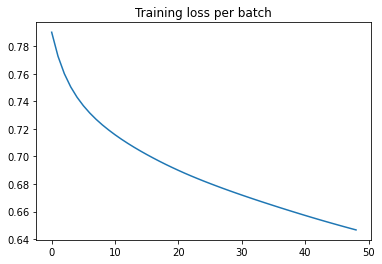

In [24]:
# training loss
plt.title('Training loss per batch')
plt.plot(train_losses[1:])

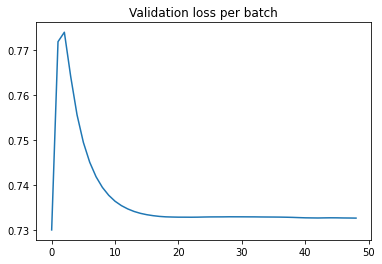

In [25]:
# validation loss
plt.title('Validation loss per batch')
plt.plot(valid_losses[1:])

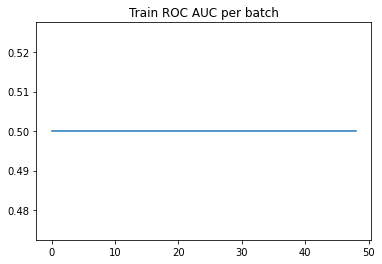

In [26]:
# train roc auc
plt.title('Train ROC AUC per batch')
plt.plot(train_roc_auc_scores[1:])

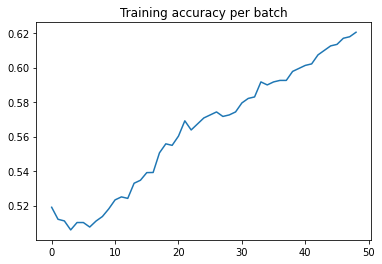

In [27]:
# training accuracy
plt.title('Training accuracy per batch')
plt.plot(train_accuracies[1:])

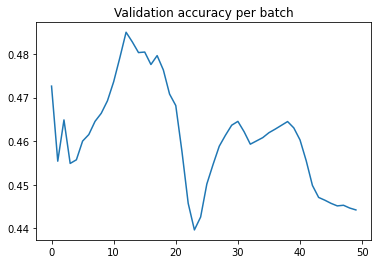

In [28]:
# validation accuracy
plt.title('Validation accuracy per batch')
plt.plot(valid_accuracies)

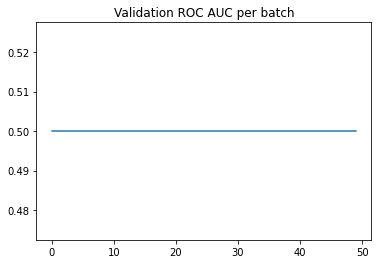

In [29]:
# validation roc auc
plt.title('Validation ROC AUC per batch')
plt.plot(valid_roc_auc_scores)

## Evaluation

Evaluate the model against the test data set.

This is representative of how the model will perform in real life as it has not seen the test data.

In [30]:
'''
Data loader for the test data.
'''
def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values,
        # transform=get_valid_transforms()
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

Get the model predictions for the test data set:

In [31]:
test_targets = []
test_outputs = []

model.cuda() # run the model on GPU
model.eval() # put model in evaluation mode so weights are not affected

# run the model against the test data and gather the predictions
for X_batch, y_batch in get_test_loader(test_df):
    X_batch, y_batch = X_batch.to(config['device']), y_batch.to(config['device'])

    y_pred = model(X_batch)

    test_targets.append(y_batch)
    test_outputs.extend([t.item() for t in y_pred])

The prediction values are in a range:

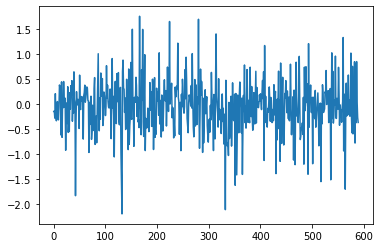

In [32]:
plt.plot(test_outputs)

To help convert to a binary classification, normalise between 0 and 1:

In [33]:
normalised_predictions = get_normalised_predictions(test_outputs)

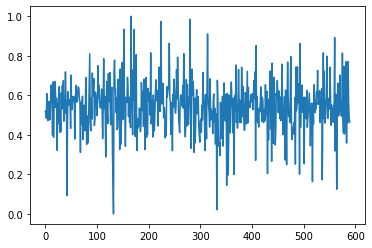

In [34]:
plt.plot(normalised_predictions)

Use 0.5 as a threshold to map the predictions into binary classifications:

In [35]:
test_targets_float = [x.cpu().numpy() for x in test_targets]
test_targets_float = np.concatenate(test_targets_float, axis=0).tolist()
test_outputs_binary = [0 if x < 0.5 else 1.0 for x in normalised_predictions]

Create and display the test results dataframe for verification:

In [36]:
test_results_df = pd.DataFrame([test_targets_float, test_outputs_binary])

test_results_df = test_results_df.transpose()
test_results_df.columns = ['label', 'prediction']

test_results_df

,label,prediction
0,1.0,1.0
1,1.0,1.0
2,1.0,0.0
3,0.0,1.0
4,1.0,1.0
...,...,...
585,0.0,0.0
586,0.0,1.0
587,0.0,1.0
588,1.0,0.0


Display a confusion matrix to give an overview of how the model classified the data:

In [37]:
pd.crosstab(test_results_df['prediction'], test_results_df['label'])

label,0.0,1.0
prediction,,
0.0,100,103
1.0,191,196


Print classification metrics:

In [38]:
print(classification_report(test_results_df['prediction'], test_results_df['label']))

              precision    recall  f1-score   support

         0.0       0.34      0.49      0.40       203
         1.0       0.66      0.51      0.57       387

    accuracy                           0.50       590
   macro avg       0.50      0.50      0.49       590
weighted avg       0.55      0.50      0.51       590



## Visualise Filters

To help understand how the model works, the convolutional filters for the first layer are plotted.

In [39]:
# load the model on the CPU
model = CustomModel()
model.load_state_dict(torch.load(os.path.join(models_dir, model_name)))
model.eval()

CustomModel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): 

In [40]:
'''
Plots the filter for a convolutional kernel.
'''
def plot_filter(kernel):
    # normalise between 0 and 1
    normalised_kernel = kernel - kernel.min()
    normalised_kernel = normalised_kernel / normalised_kernel.max()

    # make a grid of images
    filter = utils.make_grid(normalised_kernel, nrow = 12)

    # matplotlib uses (height x width x channels) format
    # pytorch uses (batch index x channel x height x width) format
    plt.imshow(filter.permute(1, 2, 0))

torch.Size([32, 1, 3, 3])


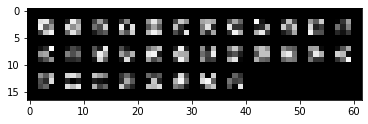

In [41]:
# get the kernel for the first layer
kernel = model.layer1[0].weight.detach().clone()

# print its size and plot its filters
print(kernel.size())
plot_filter(kernel)